In [7]:
import os
import sys
import librosa
import seaborn as sn
sys.path.append(os.path.abspath(os.path.join('../')))
from scripts.audio_loader import AudioLoader
from scripts.audio_manuplator import AudioManipulator
import scripts.visualize as vis
from scripts.results_pickler import ResultPickler
# import audio_manuplator as am
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


## Load Audio files

In [2]:
al_train = AudioLoader(directory='../data/train')
# al_test = AudioLoader(directory="../data/test",tts_file=r'/trsTest.txt')


AudioExplorer:INFO->Successfully Created AudioExplorer Class
AudioExplorer:INFO->Successfully Loaded Audio and TTS files
AudioPreprocessor:INFO->Successfully Inherited AudioExplorer Class
AudioPreprocessor:INFO->Successfully Inherited AudioExplorer Class


tr_1003_tr11004


In [3]:
df_train_audio_data = al_train.get_audio_info_with_data()
# df_test_audio_data = al_test.get_audio_info_with_data()

df_train_audio_data.head(3)


,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_1003_tr11004,4.736,Stereo,22050,"[-0.02296667, -0.025702173, -0.021117976, -0.0...",True
1,tr_10577_tr30138,8.576,Stereo,22050,"[-0.12479032, -0.14080827, -0.11907358, -0.128...",True
2,tr_10617_tr04131,4.608,Stereo,22050,"[-0.11288287, -0.1282276, -0.109205775, -0.117...",True


In [4]:
# instantiate audio manuplator class
am_train = AudioManipulator(df_train_audio_data)


AudioPreprocessor:ERROR->successfully Initialized AudioPreprocessor class!
NoneType: None
AudioPreprocessor:ERROR->successfully Initialized AudioPreprocessor class!
NoneType: None


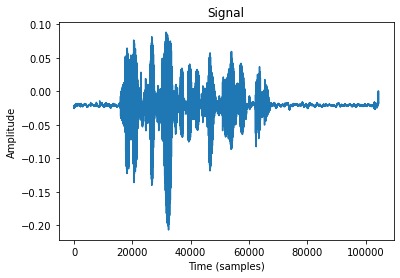

In [5]:
# Plot Time Series data of 
vis.plot_series(df_train_audio_data.loc[0,"TimeSeriesData"])


## Preprocessing the audio Data
- ### change the duration to the same size
- ### convert channels to stereo by duplicating the other channel
- ### standardize the sampling rate to the same one
- ### Data Augmentation
- ### Extract Features



### Convert Channels to Stereo by duplicating the other channel

In [8]:
def to_stereo(y,sr):
    # if it isnot stereo
    if (y.shape[0] != 2):
      y = np.vstack((y, y))

    return [y, sr]

stereo_y = []
stereo_sr = []
channels = []
for y,sr in zip(df_train_audio_data["TimeSeriesData"],df_train_audio_data["SamplingRate"]):
  str_y = to_stereo(y,sr)
  stereo_y.append(str_y[0])
  stereo_sr.append(str_y[1])
  if str_y[0].shape[0] == 1:
    channels.append("Mono")
  else:
    channels.append("Stereo")
#   S = librosa.stft(resized[0])
#   resized_duration.append(librosa.get_duration(S=S, sr=sr))
df_train_audio_data["TimeSeriesData"] = stereo_y
df_train_audio_data["SamplingRate"] = stereo_sr
df_train_audio_data["Channels"] = channels
df_train_audio_data.head()   

,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_1003_tr11004,4.736,Stereo,22050,"[[-0.02296667, -0.025702173, -0.021117976, -0....",True
1,tr_10577_tr30138,8.576,Stereo,22050,"[[-0.12479032, -0.14080827, -0.11907358, -0.12...",True
2,tr_10617_tr04131,4.608,Stereo,22050,"[[-0.11288287, -0.1282276, -0.109205775, -0.11...",True
3,tr_10399_tr23101,3.200,Stereo,22050,"[[-0.123685576, -0.14053547, -0.11865727, -0.1...",True
4,tr_10379_tr100101,4.224,Stereo,22050,"[[-0.12720865, -0.14362668, -0.12089806, -0.13...",True


In [9]:
df_train_audio_data.loc[0,"TimeSeriesData"].shape

(2, 104429)

### Change the duration to the same size
From Our Data Exploration, we found that most frequent audio files has a duration between 2 to 6. And to reduce the bias, we will pad all the audio less than 6 seconds and truncate those greater than 6.

In [17]:
def resize(y, sr, max_ms):
    num_rows, y_len = y.shape
    max_len = sr//1000 * max_ms
    # Truncate the signal to the given length
    if (y_len > max_len):
      y = y[:,:max_len]
    elif (y_len < max_len):
      # We pad on both sides
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - y_len)
      pad_end_len = max_len - y_len - pad_begin_len
      # Pad with 0s
      pad_begin = np.zeros((num_rows, pad_begin_len))
      pad_end = np.zeros((num_rows, pad_end_len))
      y = np.cat((pad_begin, y, pad_end), 1)      
    return [y, sr]

resized_duration_y = []
resized_duration_sr = []
resized_duration = []
for y,sr in zip(df_train_audio_data["TimeSeriesData"],df_train_audio_data["SamplingRate"]):
  resized = resize(y,sr,6)
  resized_duration_y.append(resized[0])
  resized_duration_sr.append(resized[1])
  resized_duration.append(librosa.get_duration(resized[0]))
df_train_audio_data["TimeSeriesData"] = resized_duration_y
df_train_audio_data["SamplingRate"] = resized_duration_sr
df_train_audio_data["Duration"] = resized_duration


In [18]:
df_train_audio_data

,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_1003_tr11004,0.005986,Stereo,22050,"[[-0.02296667, -0.025702173, -0.021117976, -0....",True
1,tr_10577_tr30138,0.005986,Stereo,22050,"[[-0.12479032, -0.14080827, -0.11907358, -0.12...",True
2,tr_10617_tr04131,0.005986,Stereo,22050,"[[-0.11288287, -0.1282276, -0.109205775, -0.11...",True
3,tr_10399_tr23101,0.005986,Stereo,22050,"[[-0.123685576, -0.14053547, -0.11865727, -0.1...",True
4,tr_10379_tr100101,0.005986,Stereo,22050,"[[-0.12720865, -0.14362668, -0.12089806, -0.13...",True
...,...,...,...,...,...,...
995,tr_1016_tr11017,0.005986,Stereo,22050,"[[-0.019123629, -0.021636378, -0.018436395, -0...",True
996,tr_10054_tr098016,0.005986,Stereo,22050,"[[-0.1266297, -0.14301273, -0.11997274, -0.128...",True
997,tr_10_tr01010,0.005986,Stereo,22050,"[[-0.0056225406, -0.0065416396, -0.0056427685,...",True
998,tr_10370_tr100092,0.005986,Stereo,22050,"[[-0.12003813, -0.13634776, -0.11590275, -0.12...",True


In [20]:
# count sampling rate frequencies
pd.DataFrame({"count": df_train_audio_data.groupby("SamplingRate")["SamplingRate"].count()})


,count
SamplingRate,
22050,1000


### Standardize Sampling Rate

### All 1000 files have the same sampling rate, which is 16000. However, we will look at the sampling rates of the test data since we need to make them the same.

In [21]:
pd.DataFrame({"count": df_test_audio_data.groupby("SamplingRate")["SamplingRate"].count(),"total": df_test_audio['SamplingRate'].count()})

,count,total
SamplingRate,,
22050,359,359


### Since our sampling rate is the same all across and good enough for training. We will move to feature extraction.

## Feature Extraction
### We can now extract features but first we convert back to mono since the librosa library expects a monochannel audio.

In [24]:

features = am_train.extract_features()

/home/dibora/AMH-STT/STT/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=132
  n_fft, y.shape[-1]


In [25]:
features.head()

,Name,Melspectogram,Melspectogram_db
0,tr_1003_tr11004,"[[2.7900546], [0.041047245], [0.0005915265], [...","[[0.0], [-18.323288], [-36.736385], [-46.55433..."
1,tr_10577_tr30138,"[[82.89139], [1.2032433], [0.15116173], [0.045...","[[-1.9073486e-06], [-18.381561], [-27.390676],..."
2,tr_10617_tr04131,"[[81.84967], [1.2774433], [0.1626715], [0.1271...","[[0.0], [-18.066753], [-27.017056], [-28.08648..."
3,tr_10399_tr23101,"[[85.895645], [1.2551126], [0.038612414], [0.0...","[[0.0], [-18.352884], [-33.472443], [-44.09732..."
4,tr_10379_tr100101,"[[86.75957], [1.2598524], [0.12583095], [0.034...","[[1.9073486e-06], [-18.379976], [-28.385298], ..."


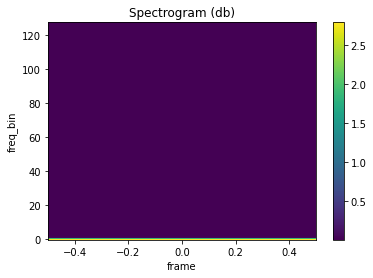

In [26]:
vis.plot_spectrogram(features.loc[0,'Melspectogram'])

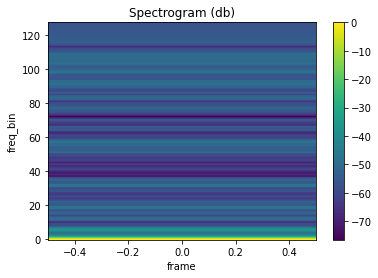

In [27]:
vis.plot_spectrogram(features.loc[0,'Melspectogram_db'])